In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

data1 = pd.read_csv('DataSet1_3.csv', sep = ',')


data1[["Date"]] = data1[["Date"]].apply(pd.to_datetime)
data1["Date"] = (data1['Date']).astype(np.int64)/1000000000

start_idx = 100
end_idx = 300

data = pd.DataFrame()

data['x'] = data1['Date'][start_idx:end_idx].to_numpy()-data1['Date'][start_idx]+1
data['y'] = data1['Close'][start_idx:end_idx].to_numpy()
data['p1'] = data1['Open'][start_idx:end_idx].to_numpy()
data['p2'] = data1['Close'][start_idx-1:end_idx-1].to_numpy()

n = round(0.8 * (end_idx - start_idx))

train = data[0:n]
test = data[n:]

x = data1['Date'][start_idx:end_idx].to_numpy()-data1['Date'][start_idx]
y = data1['Close'][start_idx:end_idx].to_numpy()

train_x = x[0:n]
train_y = y[0:n]

test_x = x[n:]
test_y = y[n:]

## МНК

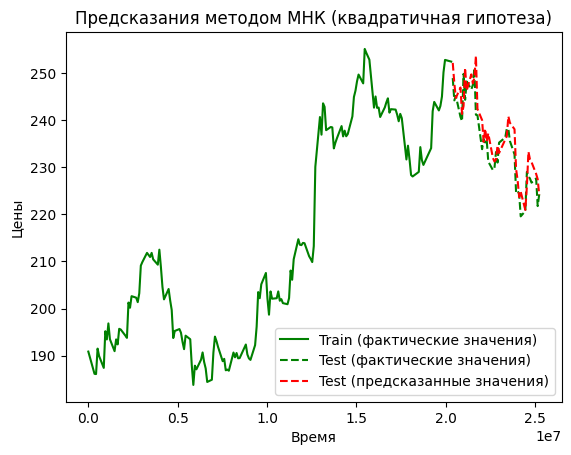

In [2]:
from scipy.optimize import curve_fit

def mapping_func(x, a, b, c, b1, b2):
    return a + b * x['x'] + c * x['x']**2 + b1 * x['p1'] + b2 * x['p2']

# Создаем DataFrame для обучения и тестирования
train_data = pd.DataFrame({'x': train_x, 'p1': train['p1'], 'p2': train['p2'], 'y': train_y})
test_data = pd.DataFrame({'x': test_x, 'p1': test['p1'], 'p2': test['p2'], 'y': test_y})

# Используем train_data вместо train_x, train_y в curve_fit
args, covar = curve_fit(mapping_func, train_data[['x', 'p1', 'p2']], train_data['y'])

a, b, c, b1, b2 = args[0], args[1], args[2], args[3], args[4]

# Применяем коэффициенты к данным
train_data['predicted'] = mapping_func(train_data, a, b, c, b1, b2)
test_data['predicted'] = mapping_func(test_data, a, b, c, b1, b2)

# Визуализация результатов
plt.plot(train_data['x'], train_data['y'], color='green', linestyle='solid', label='Train (фактические значения)')
plt.plot(test_data['x'], test_data['y'], color='green', linestyle='dashed', label='Test (фактические значения)')
plt.plot(test_data['x'], test_data['predicted'], color='red', linestyle='dashed', label='Test (предсказанные значения)')
plt.xlabel("Время")
plt.ylabel("Цены")
plt.title("Предсказания методом МНК (квадратичная гипотеза)")
plt.legend()
plt.show()


## SVM

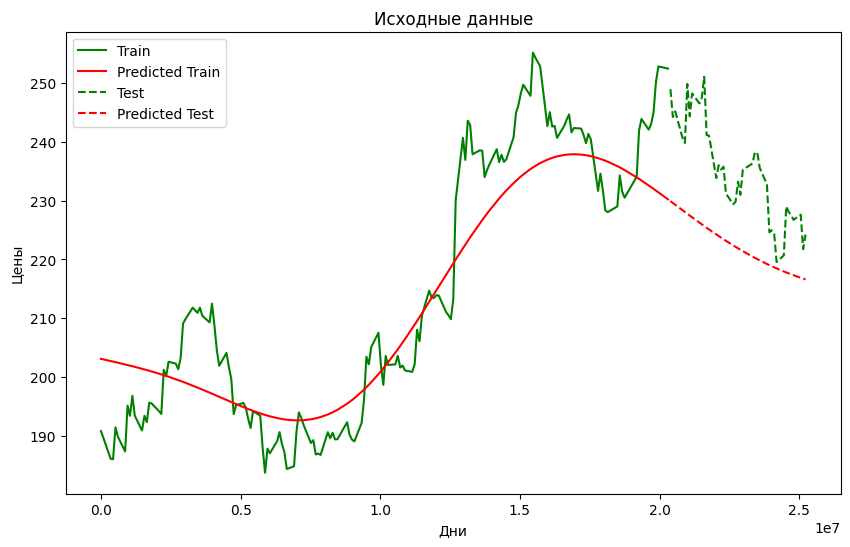

In [3]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Загрузка данных
data1 = pd.read_csv('DataSet1_3.csv', sep=',')

# Преобразование даты в числовой формат
data1[["Date"]] = data1[["Date"]].apply(pd.to_datetime)
data1["Date"] = (data1['Date']).astype(np.int64) // 10**9

# Выборка данных для обучения и тестирования
start_idx = 100
end_idx = 300

data = pd.DataFrame()
data['x'] = data1['Date'][start_idx:end_idx].values - data1['Date'][start_idx] + 1
data['y'] = data1['Close'][start_idx:end_idx].values
data['p1'] = data1['Open'][start_idx:end_idx].values
data['p2'] = data1['Close'][start_idx-1:end_idx-1].values

n = round(0.8 * (end_idx - start_idx))

train = data[:n]
test = data[n:]

# Подготовка данных для SVM
train_x = train['x'].values.reshape(-1, 1)
train_y = train['y'].values

test_x = test['x'].values.reshape(-1, 1)
test_y = test['y'].values

# Обучение модели SVM
model = SVR(kernel='rbf')  # Вы можете выбрать другие ядра вместо 'rbf', если это подходит для ваших данных
model.fit(train_x, train_y)

# Получение предсказаний для тестовой выборки
res_y_ts = model.predict(test_x)

# Получение предсказаний для тренировочной выборки для визуализации
res_y_tr = model.predict(train_x)

# Визуализация результатов
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train['x'], train['y'], color='green', linestyle='solid', label='Train')
ax.plot(train['x'], res_y_tr, color='red', linestyle='solid', label='Predicted Train')
ax.plot(test['x'], test['y'], color='green', linestyle='dashed', label='Test')
ax.plot(test['x'], res_y_ts, color='red', linestyle='dashed', label='Predicted Test')
ax.set(title="Исходные данные", xlabel="Дни", ylabel="Цены")
ax.legend()
plt.show()


C:\Users\opawk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.356e+02, tolerance: 7.747e+00
  model = cd_fast.enet_coordinate_descent(


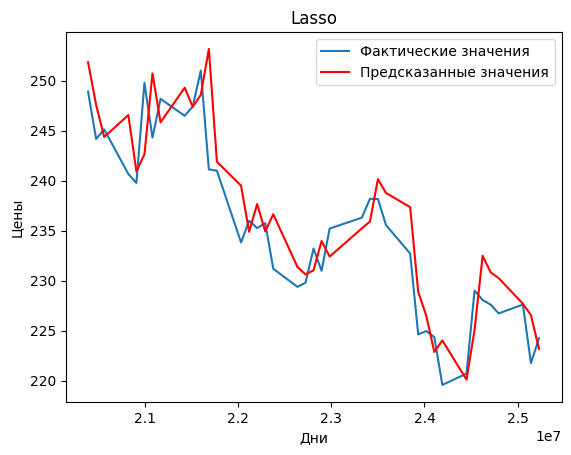

In [4]:

from sklearn.linear_model import Lasso

# Обучение модели Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(train[['x', 'p1', 'p2']], train['y'])
y_pred_lasso = lasso.predict(test[['x', 'p1', 'p2']])

# Визуализация результатов
plt.plot(test_x, test_y, label='Фактические значения')
plt.plot(test_x, y_pred_lasso, color='red', label='Предсказанные значения')
plt.xlabel("Дни")
plt.ylabel("Цены")
plt.title("Lasso")
plt.legend()
plt.show()



## PLS

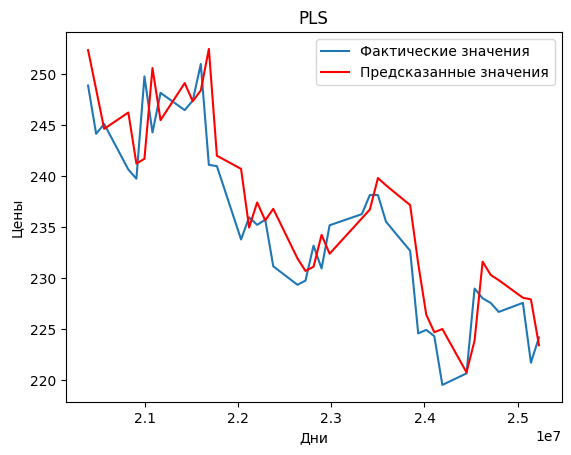

In [5]:
from sklearn.cross_decomposition import PLSRegression

# Обучение модели PLS
pls = PLSRegression(n_components=2)
pls.fit(train[['x', 'p1', 'p2']], train['y'])
y_pred_pls = pls.predict(test[['x', 'p1', 'p2']])

# Визуализация результатов
plt.plot(test_x, test_y, label='Фактические значения')
plt.plot(test_x, y_pred_pls, color='red', label='Предсказанные значения')
plt.xlabel("Дни")
plt.ylabel("Цены")
plt.title("PLS")
plt.legend()
plt.show()